# CNN   small datasets 학습


- 학습할 Data의 개수가 많지 않을 때 CNN을 통한 모형 학습이 어려울 수 있음
  - 딥러닝은 많은 양의 데이터셋을 이용해 feature engineering 과정 없이 원하는 문제를 해결할 수 있다. => **Point: 많은 데이터 양**
- Data 양이 많지 않아 딥러닝 모델의 학습에 어려움이 있을 때 사용 가능한 방법
    - **Image augmentation 활용**
        - Image에 다양한 효과를 주어 데이터양을 늘린다.
            - Train dataset은 전체 대상 이미지들을 샘플링한 것이기 때문에 모든 형태를 다 가지고 있지 않다. Data augmentation은 train set의 이미지에 다양한 효과를 주어 실제 데이터셋과의 간격을 줄인다.
            - 영상데이터의 경우 각 영상 데이터의 색변경, 이미지잘라내기, 회전시키기, 명암변경 등을 적용하여 이미지들을 추가로 만들어 data의 수를 늘린다.
        - **모델의 Overfitting을 개선시킨다.**
        - pytorch image augmentation을 위한 클래스들
            - https://pytorch.org/vision/stable/transforms.html
    - **Pre-trained network**의 활용한 **Transfer learning (전이학습)**
        - 매우 큰 데이터셋으로 미리 Training한 모델을 이용해 모델을 정의한다.
        - 성능이 좋은모델을 다량의 데이터로 학습시킨 모델을 사용하므로 적은 데이터에도 좋은 성능을 낼 수있다.

# Image Augmentation 예제

In [1]:
import torch
from torchvision import transforms

import cv2
import matplotlib.pyplot as plt

In [3]:
# 이미지 출력 함수
def image_show(img_path, transforms):
    """
    이미지 경로와 transforms를 받아서 적용한뒤 원본이미지와 처리된 이미지를 출력한다.
    transforms는 8번 적용시켜 출력한다.
    [parameter]
        img_path: str - transforms를 적용할 이미지 경로
        transforms: Transforms 객체. 단 ToTensor()가 첫번째 transforms로 정의되 있어야 한다.
    """
    #img_path의 이미지를 읽어서 rgb로 변환한다.
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    plt.rcParams['font.family'] = 'gulim' #한글설정

    plt.figure(figsize=(15, 12))
    plt.subplot(3, 3, 1)
    plt.imshow(img)
    plt.title('원본') #먼저 원본을 찍는다.

    for i in range(2, 10): #plot의 index - (2번째~9번째 axis에 이미지를 출력한다.)
        result_img = transforms (img) #원본이미지를 transform 함수에 넣어서 변형된 결과를 받는다.
        plt.subplot(3, 3, i)    
        #변환 image shape:(ch,h,w) ->matplotlib shape:(h,w,ch)
        plt.imshow(result_img.permute(1, 2, 0)) #permute는 0번 자리에 1번이, 1번 자리에 2번이 들어가게 할 수 있다.

    plt.tight_layout() #배치를 만든다.
    plt.show()

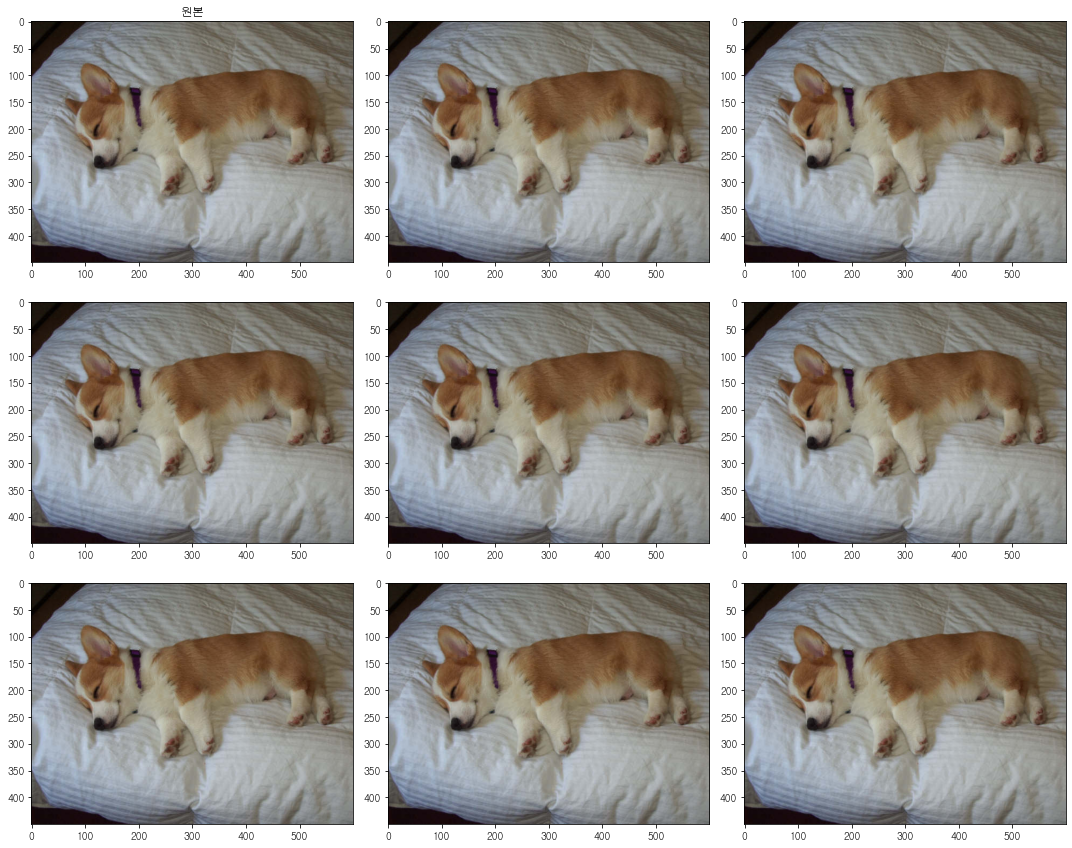

In [25]:

#transforms.Compose([변환함수1,변환함수2,....]) #변환함수들에 순서대로 이미지를 넣어서 변환한다.
#이를 통해 이미지변환의 파이프라인을 구성한다.
#핵심은 순서대로 한다는 것이다. 그렇기 때문에 순서가 매우 중요하다.


transform = transforms.Compose([
    
    #ndarray, PIL.Image 타입 ->torch.tensor
    #-(height,width,channel) ->(c,h,w)와 같이 바꿔준다.
    transforms.ToTensor()
    
    
    ###########################
    # 좌우/상하 반전. 
    ###########################
    #대부분의 변환함수는 랜덤성을 추가한다. (항상 일정하게 바뀌지 않도록 처리한다.)
    #이렇게 하는 이유는 최대한 더 많은 데이터를 추가해야 하기 때문이다.
#     , transforms.RandomHorizontalFlip(p=0.5) #반전 확률이다.
#     , transforms.RandomVerticalFlip(p=0.5) #위아래 반전 확률이다.
    
    ###########################
    # 회전
    # 회전 각도를지정한다. - 회전범위:-정수~+정수(-180 ~ +180)
    ###########################
    # , transforms.RandomRotation(degrees=180)
    #위와 같이 하면 모든 이미지가 180도 회전된 것이 아니라, -180부터 180의 범위 사이에서 회전이 된 것을 알 수 있다.
    
    
    ###########################
    # affine 이동 변환들
    #  회전, 이동, 전단 변환 처리를 한번에 할 수 있다.
    ###########################
    
    #RandomAffine은 랜덤으로 affine을 하기 때문에 적용이 되지 않을 경우도 있다.
    # , transforms.RandomAffine(degrees=(0,0), #회전(최소:-20,최대:20)/(0,0)은 회전을 시키지 않겠다는 이야기.
    #                           translate=(0.1,0.3), #좌우/상하 이동 (실수:비율)
     #                          shear=(0.0, 0.0), #전단 변환(평행사변형 형식으로 변환하는 것이다.)
      #                         scale=(1.2,1.2), #이동 후 resize하는 것이다.
       #                       )
    
    ###########################
    # 가우시안 블러
    # 잡음을 없에주는 역활.
    #kernel_size/sigma(표준편차)가 클 수록, 이미지가 흐려진다. 잡음을 더 많이 제거한다.
    #sigma - 실수값 하나: 고정, tuple: 범위 사이에서 random하게 결정.
    ###########################
#     , transforms.GaussianBlur(kernel_size=(17,17), sigma=(1, 5))
    
    ########################### 
    # 선명도 (Sharpen)
    #sharpness_factor:1-원본고 동일,1초과:sharpen
    # p: 적용될 가능성.(확률)
    ###########################
 #    , transforms.RandomAdjustSharpness(sharpness_factor=5, p=0.5) 
    ###########################
    # 색관련 변환
    #  밝기, 대비, 채도, 색 변환 처리
    # tuple로 하면 변화 비율을 (min,max로 하게 된다.)
    # 특히 ColorJitter를 쓰면 이미지를 많이 바꿀 수 있게 된다.
    ###########################
    # , transforms.ColorJitter(brightness=(0.5, 1.2), #밝기 조정
    #                        contrast=(0.8, 1.2), #대비 조정
    #                        saturation=(0.5, 1.5), #채도 조정
   #                        hue=(-0.2, 0.2)) #색 조정---조정하고 싶지 않다면 (0.0,0.0)
    #                        #hue 같은 경우는 범위가 -0.5~0.5이다.
    
    
    #########################
    # Grayscale----화면을 회색으로!
    #########################
#     , transforms.RandomGrayscale(p=0.25)
    
    ############################
    # 반전 - 확률 지정할 수 있다.
    # 픽셀값을 반전. 0<->255, 1<->254
    #p는 확률이다.
    ############################
#    , transforms.RandomInvert(p=0.7)
    
    
    ###########################
    # Center 영역 Crop
    #정수는 h와 w를 같게 하고,
    #튜플((200,100))은 h:200, w:100 같은 경우이다.
    #지정한 영역을 확대해서 보여준다.
    ###########################
#     , transforms.CenterCrop(150)
    
    ############################
    # RandomCrop - Crop 영역을 random하게 선택한다.
    ############################
#     , transforms.RandomCrop(150)

    ###########################
    # RandomResizedCrop - Random한 영역을 Crop후 지정한 종횡비 resize 한다.
    
    ###########################
#     , transforms.RandomResizedCrop(180, #crop 사이즈. 자르는 사이즈가 180*180.
#                                    scale=(0.3, 0.7), #resize 크기의 비율
#                                    ratio=(0.5, 1.5) #resize시 종횡비(가로비율,세로비율)
#                                   )
    ##############################
    # 이미지를 부분적으로 삭제한다. (픽셀값을 0으로 변경)
    # p=확률, scale=() 삭제 크기범위, ratio=() 삭제 종횡비 범위 => 지정된 튜플 비율에서 random 하게 선택되 변경됨
    # occlusion(폐색-가려지는 문제)문제에서의 한계를 해결. https://deepapple.tistory.com/8
    ###############################
#     , transforms.RandomErasing()

])
#위의 함수들에서 몇가지를 골라서 이미지를 변환시킬 수 있다.
#transform을 통해 이미지를 받아와서 변환시킨 것을 image_show을 통해 show 한다.
img_path = 'test_img/image.jpg'
image_show(img_path, transform)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


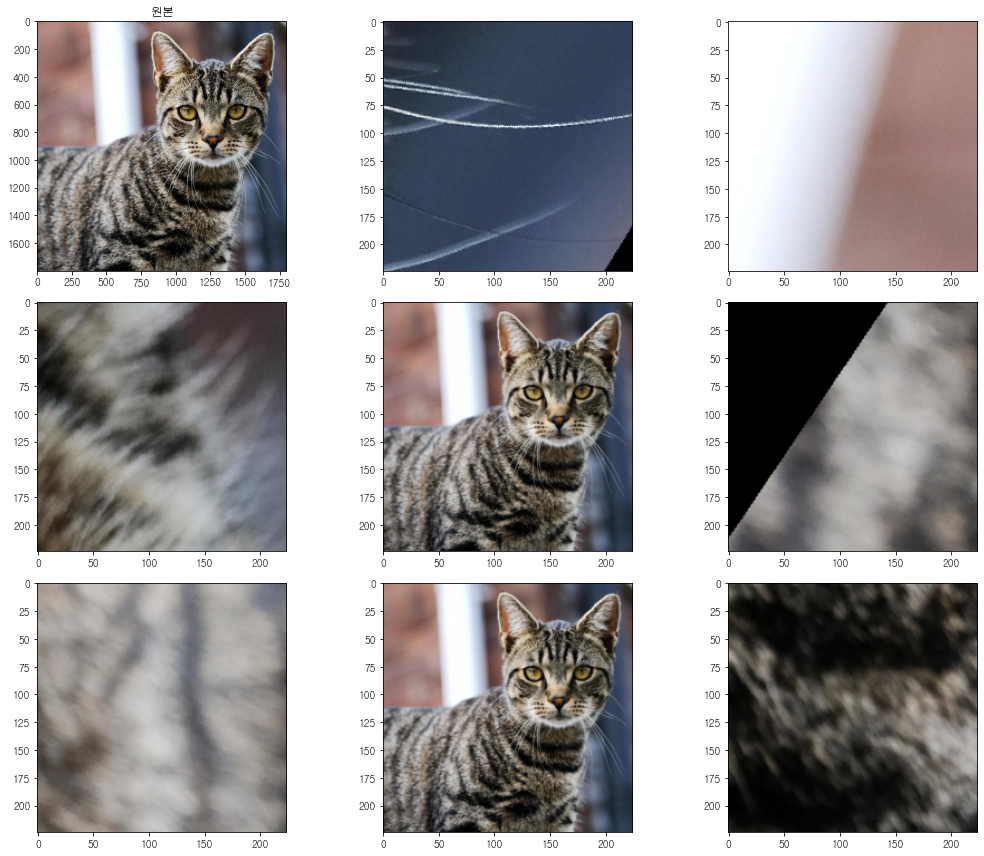

In [28]:

#####################################
# RandomApply() - 여러개 중 Random하게 여러개를 선택해서 적용한다. 선택 확률을 선택할 수 있다.
# RandomChoice() - 여러개 중 하나를 적용한다.
#####################################
transform2 = transforms.Compose([
    transforms.ToTensor() #1
    , transforms.RandomApply([ #4개의 함수들을 각각 90프로의 확률로 실행시킨다.
        transforms.RandomHorizontalFlip(), #2
        transforms.RandomVerticalFlip(), #3
        transforms.RandomRotation(45), #4
        transforms.RandomCrop((200,200)), #5
    ], p = 0.9)
    , transforms.Resize((224, 224), antialias=True) #6
])
#6개중 2~6개

#transform2 = transforms.Compose([
#     transforms.ToTensor()
#     , transforms.RandomChoice([ #여기 안에 있는 함수들 중 1개만 실행.
#         transforms.RandomRotation(45), 
#         transforms.RandomHorizontalFlip(),
#         transforms.RandomVerticalFlip(),
#     ])
#     , transforms.Resize((224, 224), antialias=True)
# ])

image_show('test_img/cat.jpg', transform2)